In [23]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from pyHalo.preset_models import CDM
from pyHalo import plotting_routines
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from galsim import InterpolatedImage, Image

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

import mejiro
from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import ft
from mejiro.utils import util
from mejiro.helpers import gs, survey_sim, psf

In [24]:
ps_dir = os.path.join(data_dir, 'output', 'power_spectra_parallelized')
r = np.load(os.path.join(ps_dir, 'r.npy'))

Average number of subhalos: 6144
Square root: 78
[1.00000000e+06 2.06913808e+06 4.28133240e+06 8.85866790e+06
 1.83298071e+07 3.79269019e+07 7.84759970e+07 1.62377674e+08
 3.35981829e+08 6.95192796e+08 1.43844989e+09 2.97635144e+09
 6.15848211e+09 1.27427499e+10 2.63665090e+10 5.45559478e+10
 1.12883789e+11 2.33572147e+11 4.83293024e+11]
[1.00000000e+06 2.15443469e+06 4.64158883e+06 1.00000000e+07
 2.15443469e+07 4.64158883e+07 1.00000000e+08 2.15443469e+08
 4.64158883e+08 1.00000000e+09 2.15443469e+09 4.64158883e+09
 1.00000000e+10 2.15443469e+10 4.64158883e+10 1.00000000e+11
 2.15443469e+11 4.64158883e+11 1.00000000e+12]
(19,)
(19,)


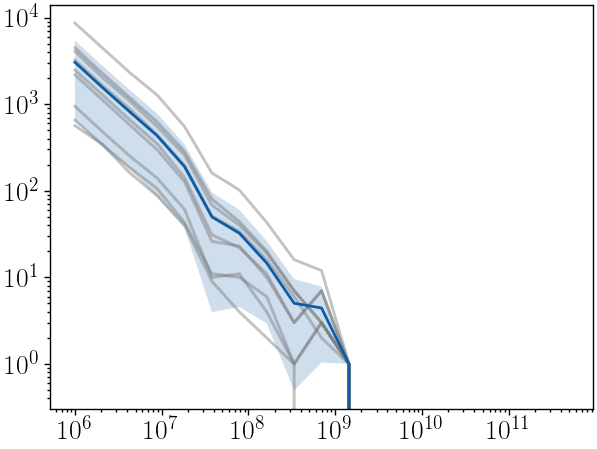

In [25]:
wdm_realizations = util.unpickle_all(ps_dir, 'wdm_realization_', '.pkl')
mdm_realizations = util.unpickle_all(ps_dir, 'mdm_realization_', '.pkl')
cdm_realizations = util.unpickle_all(ps_dir, 'cdm_realization_', '.pkl')

# get average number of subhalos
num_subhalos = []
for realization in cdm_realizations:
    num_subhalos.append(len(realization.halos))
avg = np.mean(num_subhalos)
print(f'Average number of subhalos: {round(avg)}')
print(f'Square root: {round(np.sqrt(avg))}')

cdm_list = []
for realization in cdm_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 12, 20))
    cdm_list.append(N)
    plt.loglog(m[:-1], N, alpha=0.05, color='grey')

print(m[:-1])
print(np.logspace(6, 12, 19))

m_mean = np.mean(cdm_list, axis=0)
print(m_mean.shape)

m_stdev = np.std(cdm_list, axis=0)
print(m_stdev.shape)

plt.loglog(m[:-1], m_mean)
plt.fill_between(m[:-1], m_mean - m_stdev, m_mean + m_stdev, alpha=0.2)
plt.show()

In [26]:
pprint(sorted(glob(os.path.join(ps_dir, f'res_ps_mdm_*.npy'))))

['/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run000.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run009.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run018.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run027.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run036.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run045.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run054.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run063.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run072.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run081.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_mdm_00002123_run090.npy',
 '/data/bwedig/mejiro

In [27]:
res_wdm_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_wdm_*.npy'))]
res_mdm_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_mdm_*.npy'))]

mean_wdm = np.mean(res_wdm_list, axis=0)
mean_mdm = np.mean(res_mdm_list, axis=0)

# TODO make percentile instead of std because doesn't reflect asymmetry of distribution? but unclear what percentile would mean in this context
std_wdm = np.std(res_wdm_list, axis=0, ddof=1)
std_mdm = np.std(res_mdm_list, axis=0, ddof=1)

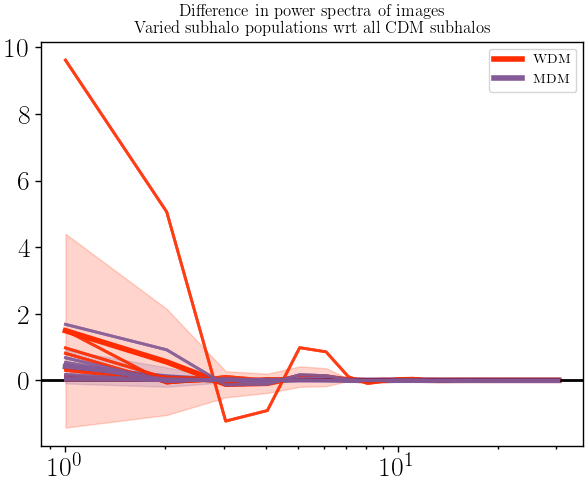

In [28]:
plt.plot(r, mean_wdm, label='WDM', color='C3', lw=4)
plt.fill_between(r, mean_wdm - std_wdm, mean_wdm + std_wdm, alpha=0.2, color='C3')
plt.plot(r, mean_mdm, label='MDM', color='C4', lw=4)
plt.fill_between(r, mean_mdm - std_mdm, mean_mdm + std_mdm, alpha=0.2, color='C4')
plt.axhline(0, color='black')

for _, res in enumerate(res_wdm_list):
    plt.plot(r, res, color='C3', alpha=0.2)

for _, res in enumerate(res_mdm_list):
    plt.plot(r, res, color='C4', alpha=0.2)

plt.xscale('log')
plt.legend()
plt.title('Difference in power spectra of images\nVaried subhalo populations wrt all CDM subhalos')
plt.show()

In [29]:
pprint(sorted(glob(os.path.join(ps_dir, f'res_ps_pos_1_*.npy'))))

['/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run000.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run009.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run018.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run027.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run036.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run045.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run054.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run063.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run072.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run081.npy',
 '/data/bwedig/mejiro/output/power_spectra_parallelized/res_ps_pos_1_00002123_run090.npy',

In [30]:
res_pos_1_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_1_*.npy'))]
res_pos_2_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_2_*.npy'))]
res_pos_3_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_3_*.npy'))]
res_pos_4_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_4_*.npy'))]
res_pos_5_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_5_*.npy'))]
res_pos_6_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_6_*.npy'))]
res_pos_7_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_7_*.npy'))]
res_pos_8_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_8_*.npy'))]
res_pos_9_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_9_*.npy'))]
res_pos_10_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_10_*.npy'))]
res_pos_11_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_11_*.npy'))]
res_pos_12_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_12_*.npy'))]
res_pos_13_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_13_*.npy'))]
res_pos_14_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_14_*.npy'))]
res_pos_15_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_15_*.npy'))]
res_pos_16_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_16_*.npy'))]
res_pos_17_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_17_*.npy'))]
res_pos_18_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_18_*.npy'))]

mean_pos_1 = np.mean(res_pos_1_list, axis=0)
mean_pos_2 = np.mean(res_pos_2_list, axis=0)
mean_pos_3 = np.mean(res_pos_3_list, axis=0)
mean_pos_4 = np.mean(res_pos_4_list, axis=0)
mean_pos_5 = np.mean(res_pos_5_list, axis=0)
mean_pos_6 = np.mean(res_pos_6_list, axis=0)
mean_pos_7 = np.mean(res_pos_7_list, axis=0)
mean_pos_8 = np.mean(res_pos_8_list, axis=0)
mean_pos_9 = np.mean(res_pos_9_list, axis=0)
mean_pos_10 = np.mean(res_pos_10_list, axis=0)
mean_pos_11 = np.mean(res_pos_11_list, axis=0)
mean_pos_12 = np.mean(res_pos_12_list, axis=0)
mean_pos_13 = np.mean(res_pos_13_list, axis=0)
mean_pos_14 = np.mean(res_pos_14_list, axis=0)
mean_pos_15 = np.mean(res_pos_15_list, axis=0)
mean_pos_16 = np.mean(res_pos_16_list, axis=0)
mean_pos_17 = np.mean(res_pos_17_list, axis=0)
mean_pos_18 = np.mean(res_pos_18_list, axis=0)

std_pos_1 = np.std(res_pos_1_list, axis=0, ddof=1)
std_pos_2 = np.std(res_pos_2_list, axis=0, ddof=1)
std_pos_3 = np.std(res_pos_3_list, axis=0, ddof=1)
# std_pos_4 = np.std(res_pos_4_list, axis=0, ddof=1)
# std_pos_5 = np.std(res_pos_5_list, axis=0, ddof=1)
# std_pos_6 = np.std(res_pos_6_list, axis=0, ddof=1)
# std_pos_7 = np.std(res_pos_7_list, axis=0, ddof=1)
# std_pos_8 = np.std(res_pos_8_list, axis=0, ddof=1)
# std_pos_9 = np.std(res_pos_9_list, axis=0, ddof=1)
# std_pos_10 = np.std(res_pos_10_list, axis=0, ddof=1)
# std_pos_11 = np.std(res_pos_11_list, axis=0, ddof=1)
# std_pos_12 = np.std(res_pos_12_list, axis=0, ddof=1)
# std_pos_13 = np.std(res_pos_13_list, axis=0, ddof=1)
# std_pos_14 = np.std(res_pos_14_list, axis=0, ddof=1)
# std_pos_15 = np.std(res_pos_15_list, axis=0, ddof=1)
# std_pos_16 = np.std(res_pos_16_list, axis=0, ddof=1)
# std_pos_17 = np.std(res_pos_17_list, axis=0, ddof=1)
# std_pos_18 = np.std(res_pos_18_list, axis=0, ddof=1)

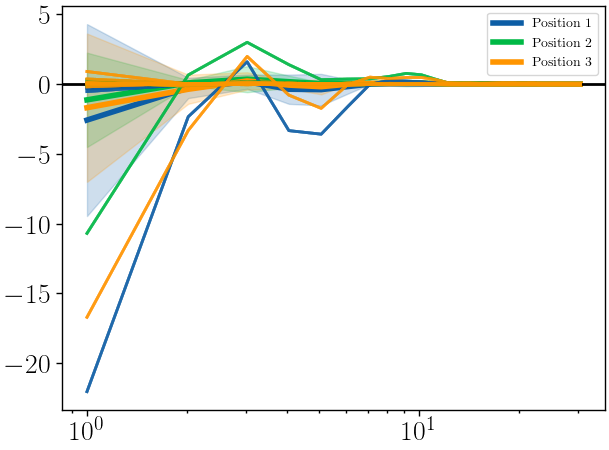

In [31]:
plt.plot(r, mean_pos_1, label='Position 1', color='C0', lw=4)
plt.fill_between(r, mean_pos_1 - std_pos_1, mean_pos_1 + std_pos_1, alpha=0.2, color='C0')
plt.plot(r, mean_pos_2, label='Position 2', color='C1', lw=4)
plt.fill_between(r, mean_pos_2 - std_pos_2, mean_pos_2 + std_pos_2, alpha=0.2, color='C1')
plt.plot(r, mean_pos_3, label='Position 3', color='C2', lw=4)
plt.fill_between(r, mean_pos_3 - std_pos_3, mean_pos_3 + std_pos_3, alpha=0.2, color='C2')
plt.axhline(0, color='black')

for _, res in enumerate(res_pos_1_list):
    plt.plot(r, res, color='C0', alpha=0.2)

for _, res in enumerate(res_pos_2_list):
    plt.plot(r, res, color='C1', alpha=0.2)

for _, res in enumerate(res_pos_3_list):
    plt.plot(r, res, color='C2', alpha=0.2)

plt.xscale('log')
plt.legend()
plt.title('')
plt.show()

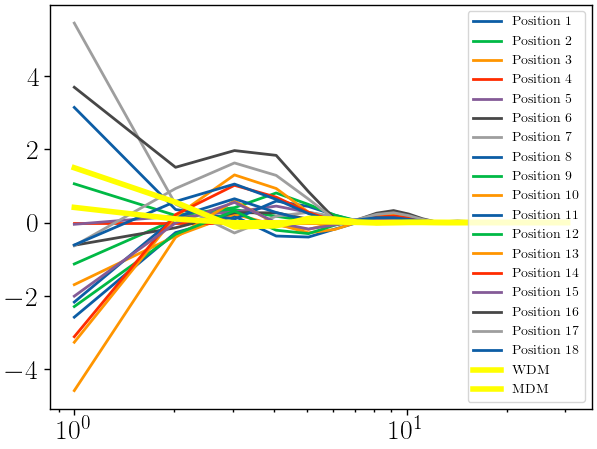

In [32]:
plt.plot(r, mean_pos_1, label='Position 1', color='C0')
plt.plot(r, mean_pos_2, label='Position 2', color='C1')
plt.plot(r, mean_pos_3, label='Position 3', color='C2')
plt.plot(r, mean_pos_4, label='Position 4', color='C3')
plt.plot(r, mean_pos_5, label='Position 5', color='C4')
plt.plot(r, mean_pos_6, label='Position 6', color='C5')
plt.plot(r, mean_pos_7, label='Position 7', color='C6')
plt.plot(r, mean_pos_8, label='Position 8', color='C7')
plt.plot(r, mean_pos_9, label='Position 9', color='C8')
plt.plot(r, mean_pos_10, label='Position 10', color='C9')
plt.plot(r, mean_pos_11, label='Position 11', color='C0')
plt.plot(r, mean_pos_12, label='Position 12', color='C1')
plt.plot(r, mean_pos_13, label='Position 13', color='C2')
plt.plot(r, mean_pos_14, label='Position 14', color='C3')
plt.plot(r, mean_pos_15, label='Position 15', color='C4')
plt.plot(r, mean_pos_16, label='Position 16', color='C5')
plt.plot(r, mean_pos_17, label='Position 17', color='C6')
plt.plot(r, mean_pos_18, label='Position 18', color='C7')
plt.plot(r, mean_wdm, label='WDM', color='yellow', lw=4)
plt.plot(r, mean_mdm, label='MDM', color='yellow', lw=4)
# plt.axhline(0, color='black')

plt.xscale('log')
plt.legend(loc=4)
plt.title('')
plt.show()